### Estimate EEG Data without Artifcats

In [2]:
%matplotlib inline

In [19]:
import mne
import numpy as np
from mne.datasets import sample
import matplotlib.pyplot as plt
import h5py
import time

#### Load Forward Model

In [4]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
info = mne.io.read_info(raw_fname) 
fwd = mne.read_forward_solution("sample_forward_model")

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Reading forward solution from sample_forward_model...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read


<ipython-input-4-4a7190ffba04>:4: RuntimeWarning: This filename (sample_forward_model) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution("sample_forward_model")


    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [5]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)

    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


In [6]:
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 60 sensors x 7498 dipoles


In [7]:
n_dipoles = leadfield.shape[1]
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]

#### Use Forward Model to Estimate Data

In [8]:
n_sensors = 60
# n_times = 3600
fs_gen = 200
time_step = 1.0/fs_gen # sample freq = 200 was 0.5
n_times = 10 * fs_gen  # try 10 s of generation
# time_step = 0.08
frequency = 200
channel_names = [str(i) for i in range(60)]

Random source

In [9]:
z = np.dot(np.random.randn(n_dipoles, n_sensors), np.random.randn(n_sensors, n_times)) # * 1e-9

In [10]:
#z = np.power(np.dot(np.random.randn(n_dipoles, n_sensors), np.random.randn(n_sensors, n_times)), 4) * 1e-13

'0.162100'

In [11]:
format(np.sum(np.abs(z)), "f")

'92212884.578500'

In [12]:
# (np.tile(np.sum(z, axis=0), 60)).reshape(n_sensors, n_times).shape

In [13]:
# n_dipoles = leadfield.shape[1]
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
# z = np.random.randn(n_dipoles, n_dipoles) * 1e-9
stc = mne.SourceEstimate(z, vertices, tmin=0., tstep=time_step)
# leadfield = mne.apply_forward(fwd_fixed, stc, info).data
leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9

Projecting source estimate to sensor space...
[done]


<ipython-input-13-37186620eb2c>:6: RuntimeWarning: The maximum current magnitude is 49034218234.5 nAm, which is very large. Are you trying to apply the forward model to noise-normalized (dSPM, sLORETA, or eLORETA) values? The result will only be correct if currents (in units of Am) are used.
  leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9


In [20]:
start = time.time()
z = np.dot(np.random.randn(n_dipoles, n_sensors), np.random.randn(n_sensors, n_times))
vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
stc = mne.SourceEstimate(z, vertices, tmin=0., tstep=time_step)
leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9
print(time.time() - start)

Projecting source estimate to sensor space...
[done]
0.36965417861938477


<ipython-input-20-555bd2dfeab4>:5: RuntimeWarning: The maximum current magnitude is 43395551087.8 nAm, which is very large. Are you trying to apply the forward model to noise-normalized (dSPM, sLORETA, or eLORETA) values? The result will only be correct if currents (in units of Am) are used.
  leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9


### Save Data to .fif

In [52]:
filename = "test_raw.fif"

In [53]:
data = leadfield.data
info = mne.create_info(channel_names, frequency, 
                       "eeg")#, montage='standard_1020')

In [54]:
customraw = mne.io.RawArray(data, info)
customraw.save(filename, overwrite=True)

Creating RawArray with float64 data, n_channels=60, n_times=2000
    Range : 0 ... 1999 =      0.000 ...     9.995 secs
Ready.
Overwriting existing file.
Writing /Users/DanielLongo 1/Desktop/eegML/forward_model/test_raw.fif
Closing /Users/DanielLongo 1/Desktop/eegML/forward_model/test_raw.fif [done]


In [55]:
leadfield.shape

(60, 2000)

### Load Data

In [56]:
plt.ion()

In [57]:
x = mne.io.read_raw_fif(filename)

Opening raw data file /Users/DanielLongo 1/Desktop/eegML/forward_model/test_raw.fif...
Isotrak not found
    Range : 0 ... 1999 =      0.000 ...     9.995 secs
Ready.


In [58]:
raw = x

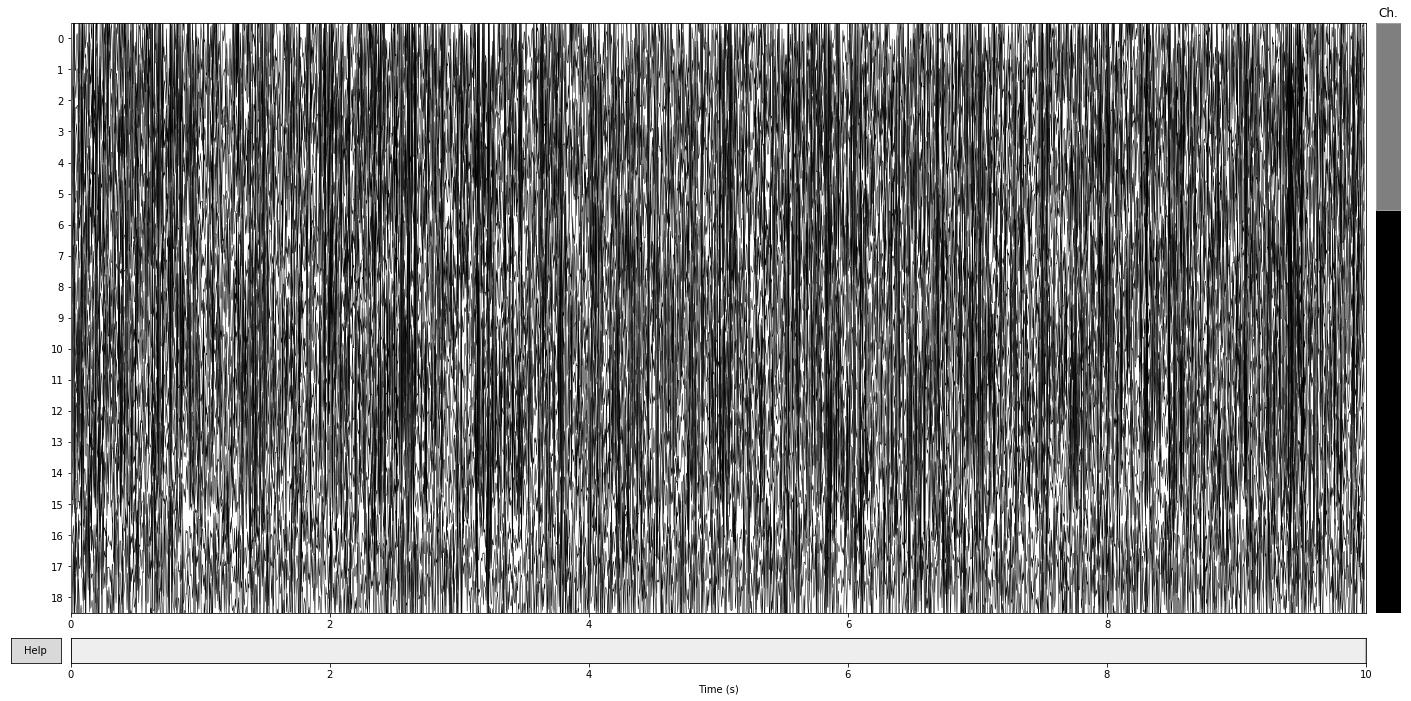

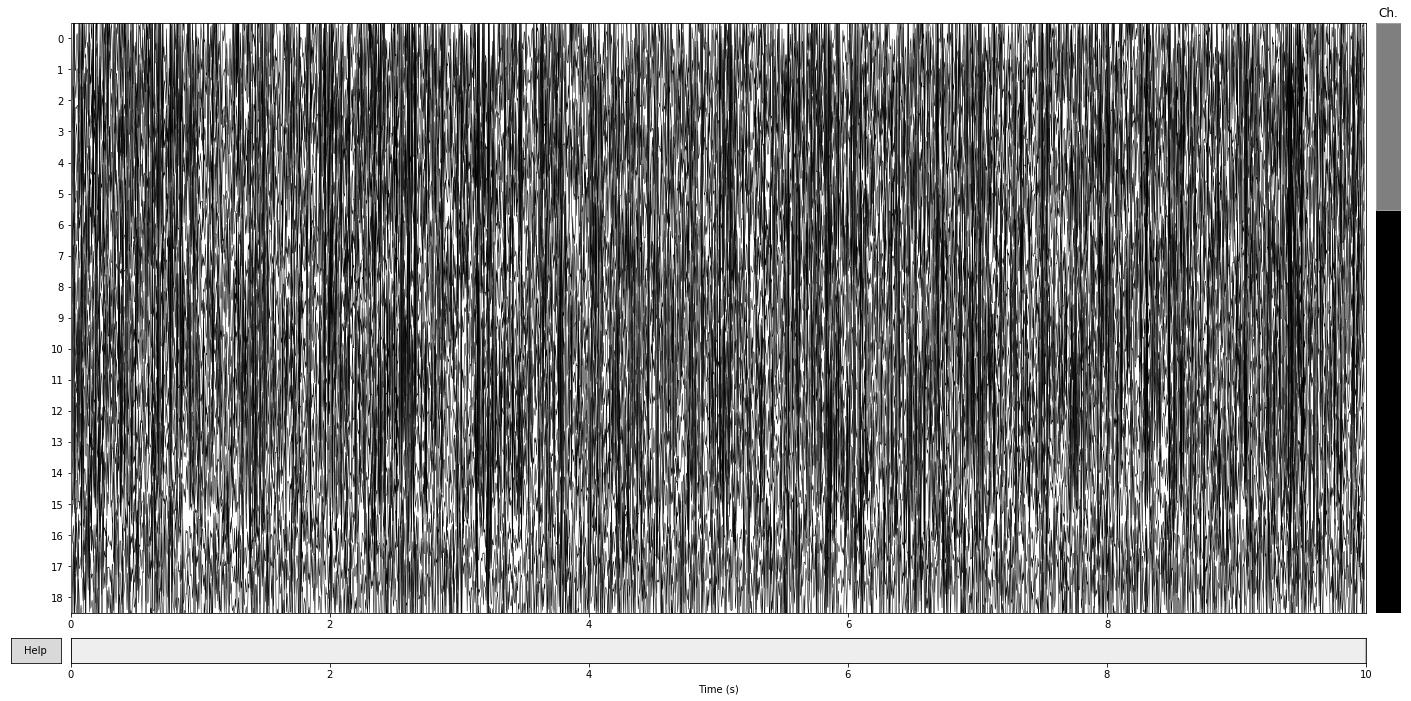

In [59]:
raw.plot(n_channels=19, block=False)

### To Visualize

In [60]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [61]:
stacklineplot.show_epoch_centered(x, 100, epoch_width_sec=400, chstart=0, chstop=50, fs=frequency, ylabels=channel_names, yscale=3.0)
plt.title('Sample Data');

AttributeError: 'Raw' object has no attribute 'shape'

In [ ]:
fig = leadfield.plot(exclude=(), time_unit='s')

In [ ]:
picks = mne.pick_types(leadfield.info, meg=False, eeg=True, eog=False)
leadfield.plot(spatial_colors=True, gfp=True, picks=picks, time_unit='s')
leadfield.plot_topomap(time_unit='s')

### Old

In [15]:
import stacklineplot 

(2000,)


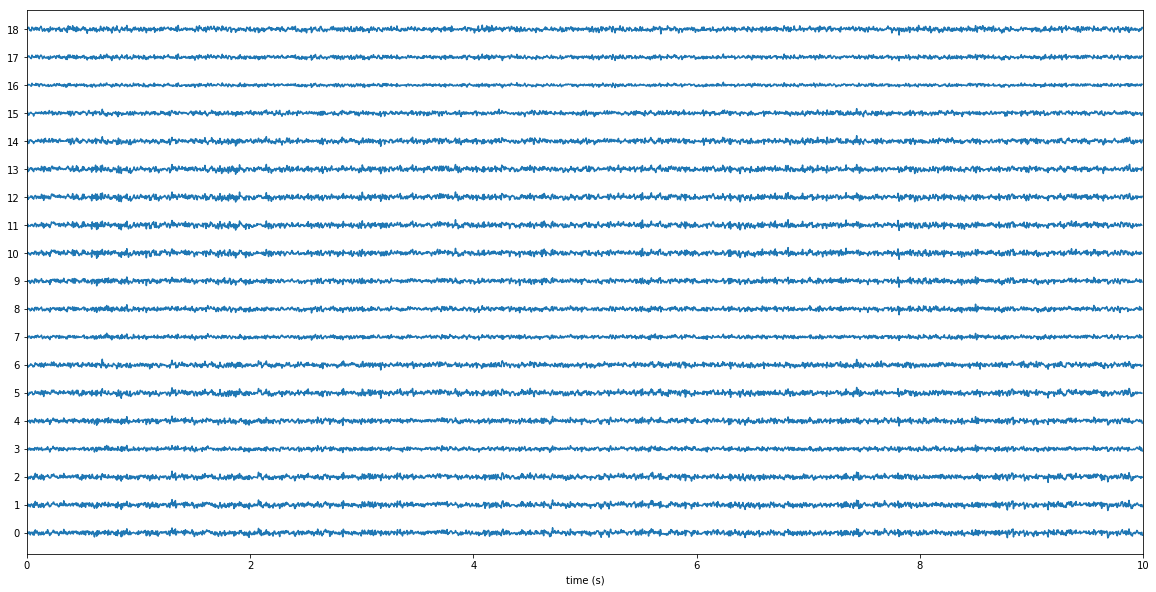

In [16]:
# plot 10s epochs (multiples in DE)
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10


signals = leadfield
electrode_labels = list(range(n_sensors))
ch0, ch1 = (0,19)
DE = 1 # how many 10s epochs to display
epoch = 0; ptepoch = 10*int(fs_gen)
dp = 0 # int(0.5*ptepoch) # offset 
print(np.shape(signals[ch0:ch1,epoch*ptepoch+dp:(epoch+DE)*ptepoch+dp][1]))
stacklineplot.stackplot(signals[ch0:ch1,epoch*ptepoch+dp:(epoch+DE)*ptepoch+dp],seconds=DE*10.0, ylabels=electrode_labels[ch0:ch1], yscale=0.3)

In [25]:
f = h5py.File('mytestfile.hdf5', 'r+')

In [30]:
h5f = h5py.File('test.h5', 'r+')
h5f.create_dataset('test', data=leadfield.data)
# h5f.close()
h5f = h5py.File('test.h5','r')
type(h5f['test'][:])

RuntimeError: Unable to create link (Name already exists)

In [26]:
f.create_dataset("generated_data_c", data=leadfield.data)

<HDF5 dataset "generated_data_c": shape (60, 36000), type "<f8">

In [46]:
dset =  h5py.Group.create_dataset(name="generated_data", data=leadfield.data)

TypeError: create_dataset() missing 1 required positional argument: 'self'

In [28]:
x = f["generated_data_c"]